`Can we approximately sample from a Bayesian posterior distribution if we are only allowed to touch a small mini-batch of data-items for every sample we generate ?`

For large high dimensional datasets, nature of relationships between model parameters and the variability of uncertainty reduction in the parameters can be measured with bayesian models and sampling algorithms.

The capacity of sampling algorithms to sample from exact or approximate bayesian posterior of the parameters in reasonable time is therefore very useful.

Based on results from a recent paper, a simple implementation of constant stochastic gradient is shown to have approximately sampling from the posterior. The goal of this notebook is the replicate the results and test the algorithm on a very large dataset.

Reference: https://www.slideshare.net/hustwj/austerity-in-mcmc-land-cutting-the-computational-budget

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
from collections import OrderedDict
import warnings
import theano
import numpy as np
rng = np.random.RandomState(0)

In [3]:
import pandas as pd
import theano.tensor as tt
import seaborn as sns

In [4]:
class ConstantStochasticGradient(pm.step_methods.sgmcmc.BaseStochasticGradient):
    R"""
    ConstantStochasticGradient: approximates stochastic variational inference
    
    It approximates stochastic variational inference
    where it differs from SGFS and many other MCMC techniques which
    converge towards the exact posterior. In comparison to SGFS the paper 
    discusses a proof for the optimal preconditioning matrix
    based on variational inference, so there is no additional input.
     
    Parameters
    -----
    vars : list
        model variables

    References
    -----
    -   Stochastic Gradient Descent as Approximate Bayesian Inference
        https://arxiv.org/pdf/1704.04289v1.pdf
    """

    def __init__(self, vars=None, **kwargs):
        """
        Parameters
        ----------
        vars : list 
            Theano variables, default continuous vars
        kwargs: passed to BaseHMC
        """
        super(ConstantStochasticGradient, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_C: Noise Covariance Moving Average
        self.avg_C = theano.shared(np.zeros((self.q_size, self.q_size)), name='avg_C')
        self.t = theano.shared(1, name='t')
        # Init training fn
        self.training_fn = self.mk_training_fn()

    def mk_training_fn(self):
        """The Constant Stochastic Gradient Step Fn with Optimal Preconditioning Matrix"""
        q_size = self.q_size
        avg_C = self.avg_C
        t = self.t
        updates = self.updates
        # Trying to stick to variables names as given in the publication
        # https://arxiv.org/pdf/1704.04289v1.pdf
        S = self.batch_size
        N = self.total_size
        
        # inputs
        random = self.random
        inarray = self.inarray
        
        # gradient of log likelihood
        gt = -1 * (1./S) * (self.dlogp_elemwise.sum(axis=0) + (S/N)*self.dlog_prior)    

        # update moving average of Noise Covariance
        gt_diff = (self.dlogp_elemwise - self.dlogp_elemwise.mean(axis=0))
        V = (1./(S-1)) * theano.dot(gt_diff.T, gt_diff)
        C_t = (1. - 1. / t) * avg_C + (1. / t) * V        
        # BB^T = C 
        B = tt.switch(t < 0, tt.eye(q_size), tt.slinalg.cholesky(C_t))            
        # Optimal Preconditioning Matrix
        H = (2.*S/N)*tt.nlinalg.matrix_inverse(C_t)
        # step value on the log likelihood gradient preconditioned with H
        step = -1*theano.dot(H, gt.dimshuffle([0, 'x'])) 
        
        # sample gaussian noise dW
        dW = random.normal((q_size, 1), dtype=theano.config.floatX, avg=0.0, std=1.0)        
        # noise term is inversely proportional to batch size
        noise_term = (1./np.sqrt(S))*theano.dot(H, theano.dot(B, dW))
        # step + noise term
        dq = (step + noise_term).flatten()
        
        # update time and avg_C 
        updates.update({avg_C: C_t, t: t + 1})
        
        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        return f
        
    @staticmethod
    def competence(var):
        if var.dtype in continuous_types:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE

### Problem: A multivariate regression problem on the Protein Structure Properties dataset available at the [uci repo](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv --directory-prefix=/tmp/

--2017-09-19 19:28:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3528710 (3.4M) [text/csv]
Saving to: ‘/tmp/CASP.csv.1’

CASP.csv.1          100%[===================>]   3.37M  7.38MB/s    in 0.5s    

2017-09-19 19:28:26 (7.38 MB/s) - ‘/tmp/CASP.csv.1’ saved [3528710/3528710]



### Load dataset

In [6]:
batch_size = 50
raw_data = pd.read_csv('/tmp/CASP.csv', delimiter=',')
data = (raw_data - raw_data.mean())/raw_data.std()
q_size = data.shape[1]-1
q_name = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']

In [7]:
data_N = data.size/len(data.columns)
train_test_split = 0.95
ixs = rng.randint(data_N, size=int(data_N*train_test_split))
neg_ixs = list(set(range(data_N)) - set(ixs))
train_df = data.iloc[ixs]
test_df = data.iloc[neg_ixs]

N = train_df.size / len(train_df.columns)
n_test = test_df.size / len(test_df.columns)

In [8]:
train_X = train_df[q_name].as_matrix()
train_Y = train_df['RMSD'].as_matrix()

test_X = test_df[q_name].as_matrix()
test_Y = test_df['RMSD'].as_matrix()

In [9]:
ixs = range(batch_size)
model_input = theano.shared(train_X[ixs], name='X')
model_output = theano.shared(train_Y[ixs], name='Y')

with pm.Model() as model:
    # Unknown parameters
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    b1 = pm.Normal("Slope", mu=0.0, sd=1.0, shape=(q_size,))
    std = pm.HalfNormal("std", sd=1.0)

    # Identity Link Function
    mu = b0 + theano.dot(model_input, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=model_output)

In [10]:
# Generator that returns mini-batches in each iteration
def create_minibatches(batch_size):
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(N, size=batch_size)
        yield (train_X[ixs], train_Y[ixs])

# Tensors and RV that will be using mini-batches
minibatches = create_minibatches(batch_size)
minibatch_tensors = [model_input, model_output]

In [11]:
draws = 10000

with model:
    csg_step_method = ConstantStochasticGradient(vars=model.vars, total_size=N, batch_size=batch_size,
                                                 minibatches=minibatches, minibatch_tensors=minibatch_tensors) 
    csg_trace = pm.sample(draws=draws, step=csg_step_method, init=None) 
    
with model:
    sgfs_step_method = pm.step_methods.SGFS(vars=model.vars, step_size=1.0, total_size=N, batch_size=batch_size,
                                            minibatches=minibatches, minibatch_tensors=minibatch_tensors)  
    sgfs_trace = pm.sample(draws=draws, step=sgfs_step_method, init=None) 
    
with nuts_model:
    model_input.set_value(train_X)
    model_output.set_value(train_Y)
    nuts_trace = pm.sample(draws=draws)     

/Users/shashank/.virtualenvs/pym3/lib/python2.7/site-packages/pymc3-3.1-py2.7.egg/pymc3/step_methods/sgmcmc.py:107: UserWarning: Warning: Stocastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
100%|██████████| 10500/10500 [00:11<00:00, 942.37it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 54,541:  20%|██        | 40893/200000 [00:38<02:30, 1054.93it/s]   
Convergence archived at 40900
Interrupted at 40,900 [20%]: Average Loss = 77,176
100%|██████████| 10500/10500 [13:17<00:00,  8.27it/s]


## NUTS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bb37a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bbcf0d0>]], dtype=object)

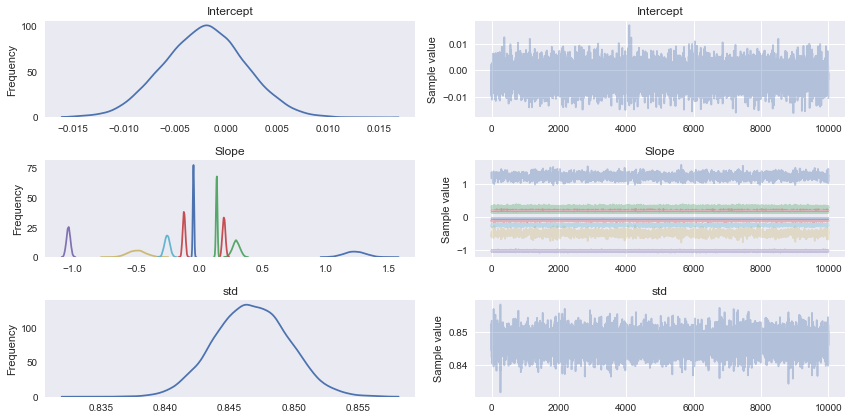

In [20]:
pm.traceplot(nuts_trace)

## Preconditioned CSG Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114a56f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cc1e750>]], dtype=object)

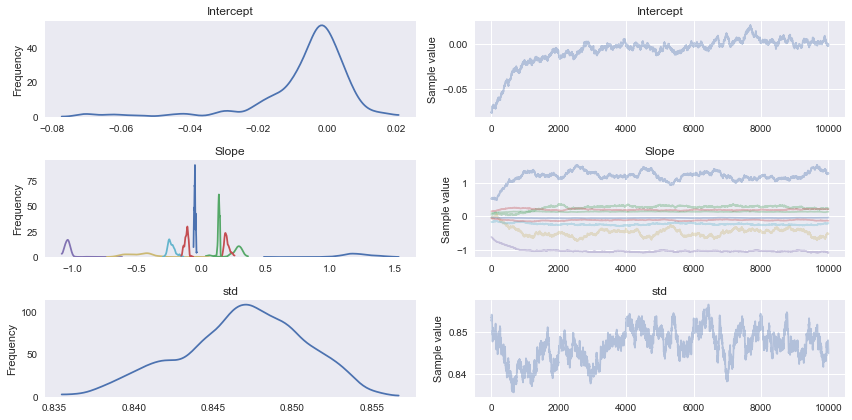

In [12]:
pm.traceplot(csg_trace)

## SGFS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ccf1990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d9f7dd0>]], dtype=object)

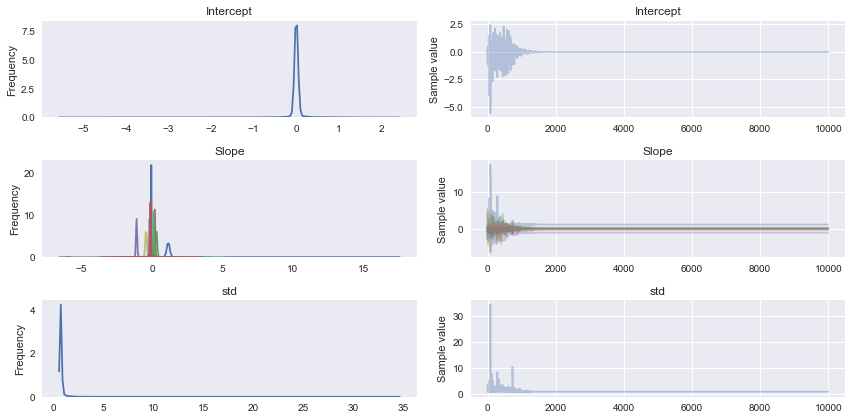

In [13]:
pm.traceplot(sgfs_trace)

## Mean Absolute Error on Test Dataset

In [14]:
# Replace shared variables with testing set
model_input.set_value(test_X)
model_output.set_value(test_Y)

# Creater posterior predictive samples
sgfs_ppc = pm.sample_ppc(sgfs_trace, model=model, samples=500, random_seed=0)
sgfs_pred = sgfs_ppc['y_obs'].mean(axis=0)

# Creater posterior predictive samples
csg_ppc = pm.sample_ppc(csg_trace, model=model, samples=500, random_seed=0)
csg_pred = csg_ppc['y_obs'].mean(axis=0)

# Nuts predictive samples
nuts_ppc = pm.sample_ppc(nuts_trace, model=model, samples=500, random_seed=0)
nuts_pred = nuts_ppc['y_obs'].mean(axis=0)

sgfs_diff = sgfs_pred-test_Y
csg_diff = csg_pred-test_Y
nuts_diff = nuts_pred-test_Y

100%|██████████| 500/500 [00:00<00:00, 658.32it/s]


In [23]:
print('The NUTS Mean Absolute Error is {}'.format(np.sum(np.abs(nuts_diff))/test_Y.size))
print('The CSG Mean Absolute Error is {}'.format(np.sum(np.abs(csg_diff))/test_Y.size))
print('The SGFS Mean Absolute Error is {}'.format(np.sum(np.abs(sgfs_diff))/test_Y.size))

The NUTS Mean Absolute Error is 0.706350243098
The CSG Mean Absolute Error is 0.707004843138
The SGFS Mean Absolute Error is 0.704216649646


In comparison, the best performing regression models from sklearn has accuracy 0.79

In [83]:
from sklearn import linear_model
sklearn_regression_model = {
    'Ridge': linear_model.Ridge (alpha = .5),
    'Lasso': linear_model.Lasso(alpha = 0.1),
    'BayesianRidge': linear_model.BayesianRidge(),
    'OLS': linear_model.LinearRegression(),
}
for name, reg in sklearn_regression_model.items():
    reg.fit(train_X, train_Y) 
    pred = reg.predict(test_X)
    diff = pred-test_Y
    print('The {} Mean Absolute Error is {}'.format(name, np.sum(np.abs(diff))/test_Y.size))

The BayesianRidge Mean Absolute Error is 0.705775225403
The OLS Mean Absolute Error is 0.705739946132
The Ridge Mean Absolute Error is 0.705748180444
The Lasso Mean Absolute Error is 0.798798476908


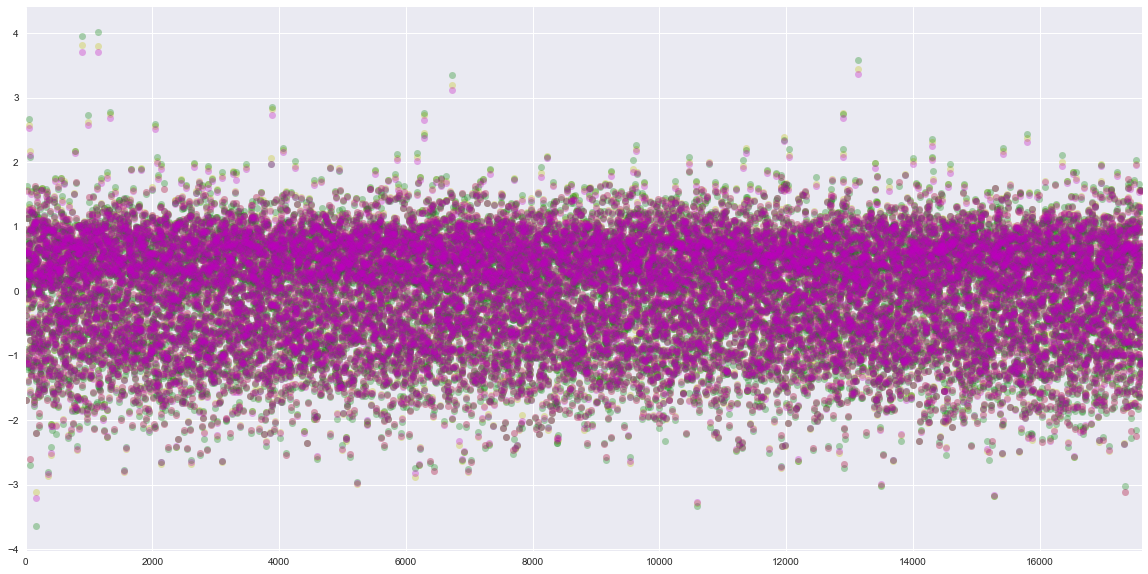

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.tsplot(data=nuts_diff, ax=ax, color="y", interpolate=False, alpha=0.3)
sns.tsplot(data=sgfs_diff, ax=ax, color="g", interpolate=False, alpha=0.3)
sns.tsplot(data=csg_diff, ax=ax, color="m", interpolate=False, alpha=0.3)

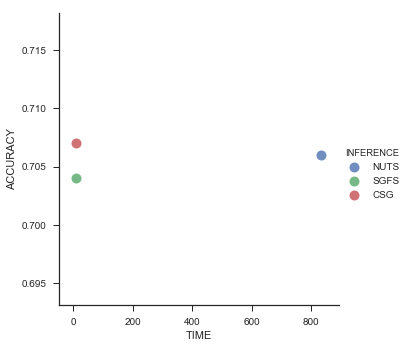

In [69]:
import seaborn as sns
sns.set(style="ticks")

df = pd.DataFrame([{'TIME': (38 + (13*60 + 17)), 'INFERENCE': 'NUTS', 'ACCURACY': .706},
                   {'TIME': (11), 'INFERENCE': 'SGFS', 'ACCURACY': .704},
                   {'TIME': (11), 'INFERENCE': 'CSG', 'ACCURACY': .707}])

g = sns.lmplot('TIME', # Horizontal axis
           'ACCURACY', # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="INFERENCE", # Set color
           size=5,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

### Figure 1

Posterior distribution f(θ) ∝ exp{−N (θ)} (blue) and stationary sampling distributions q(θ) of the iterates of SGD (cyan) 

In [32]:
def posterior_covariance(step_method, trace):
    bij = pm.DictToArrayBijection(step_method.ordering, step_method.model.test_point)
    q_size = bij.map(step_method.model.model.test_point).size
    sample_size = len(trace)
    posterior = np.empty((q_size, sample_size))
    for index, point in enumerate(trace):
        posterior[:, index] = bij.map(point)
    posterior_minus_mean = posterior - np.asmatrix(posterior.mean(axis=1)).T
    cov = np.matmul(posterior_minus_mean, posterior_minus_mean.T)
    return posterior_minus_mean, cov

def projection(posterior, cov):
    U, S, V_h = np.linalg.svd(a=cov, compute_uv=True, full_matrices=True)
    first_projection = V_h[0, :]
    last_projection = V_h[-1, :]
    q_size, samples = posterior.shape
    projection_matrix = np.empty((samples, 2))
    for i in range(samples):
        projection_matrix[i, 0] = np.matmul(first_projection, posterior_minus_mean[:, i])
        projection_matrix[i, 1] = np.matmul(last_projection, posterior_minus_mean[:, i])
    return projection_matrix

burn_in = 500

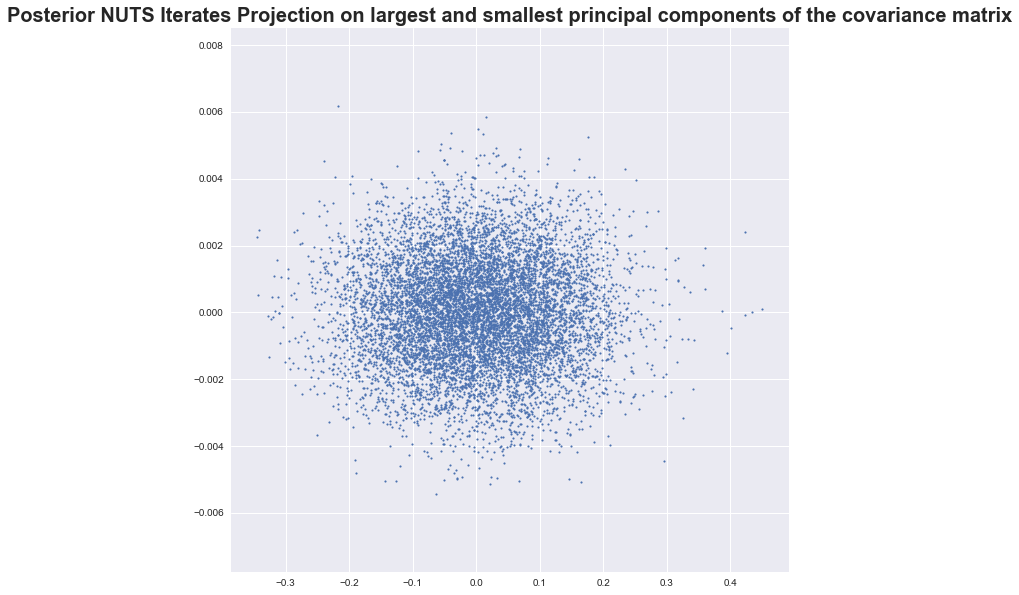

In [41]:
posterior_minus_mean, cov = posterior_covariance(csg_step_method, nuts_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior NUTS Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'],s=3)

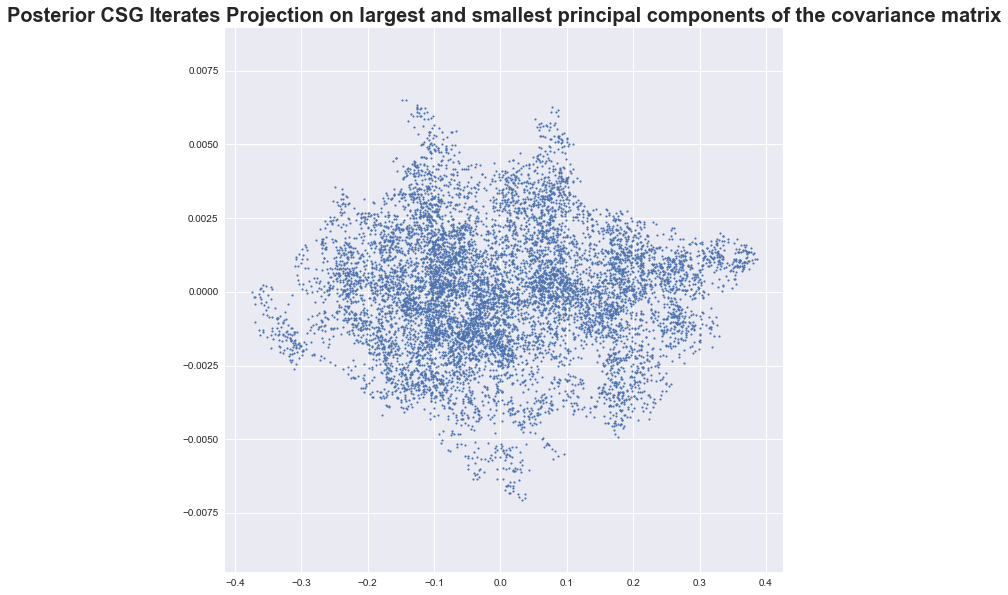

In [33]:
posterior_minus_mean, cov = posterior_covariance(csg_step_method, csg_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior CSG Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'], s=3)

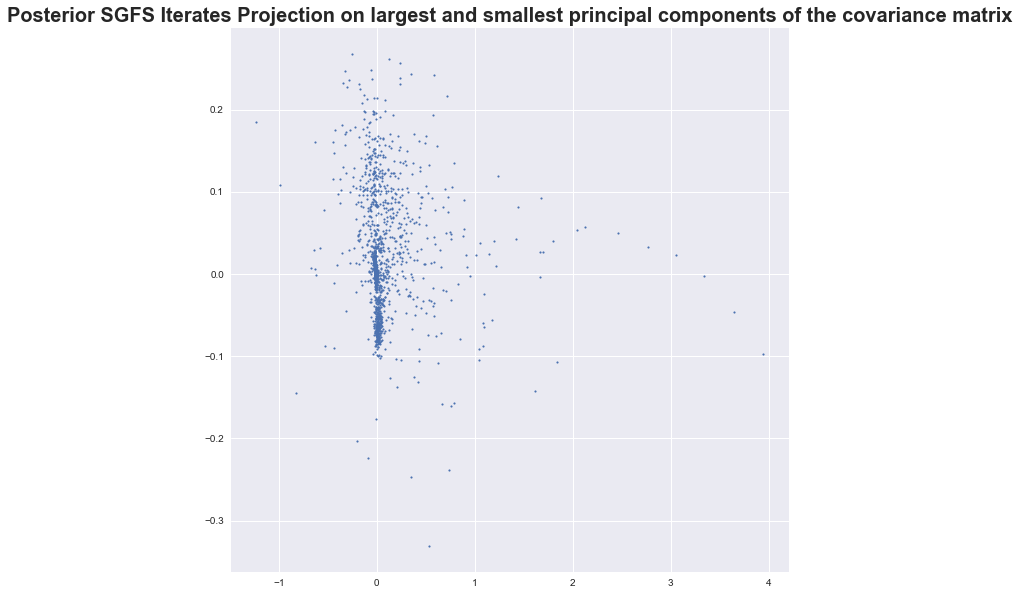

In [38]:
posterior_minus_mean, cov = posterior_covariance(sgfs_step_method, sgfs_trace[500:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior SGFS Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'], s=3)